# **Project 6: Ocean warming contribution to sea level rise**

by Serigne DIOUF (IMT) and Markus REINERT (IUEM)

*on 17 January 2020*

In [0]:
!pip install gcsfs
!pip install xarray
!pip install zarr
!pip install gsw
!apt-get -qq install python-cartopy python3-cartopy

import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as crs
import cartopy.feature as cfeature
import gsw
import gcsfs
import xarray as xr
from sklearn.linear_model import LinearRegression

     |████████████████████████████████| 3.3MB 2.9MB/s 
     |████████████████████████████████| 3.8MB 39.8MB/s 
  Created wheel for zarr: filename=zarr-2.4.0-cp36-none-any.whl size=127068 sha256=2b0b3991d18ca901909f8158d473261b0e26b9b6813a63124df903c18473d888
  Stored in directory: /root/.cache/pip/wheels/e1/5b/25/24c685604b91139aba00a5b6299b53e7a0661f737f27782559
  Created wheel for asciitree: filename=asciitree-0.3.3-cp36-none-any.whl size=5036 sha256=ee39d2fd452bedef1ce7c77dc1e934974cd7cf0e9b06e5e191c276bc94206e13
  Stored in directory: /root/.cache/pip/wheels/1d/d9/58/9808b306744df0208fccc640d3d9952a5bc7468502d42897d5


In [0]:
plt.rcParams["font.size"] = 14
plt.rcParams["axes.titlesize"] = "x-large"

# Loading the dataset

In [0]:
fs = gcsfs.GCSFileSystem(project="alert-ground-261008")
gcsmap = fs.get_mapper("opendata_bdo2020/EN.4.2.1.f.analysis.g10.zarr")
ds = xr.open_zarr(gcsmap)
print(ds)

<xarray.Dataset>
Dimensions:                          (bnds: 2, depth: 42, lat: 173, lon: 360, time: 832)
Coordinates:
  * depth                            (depth) float32 5.0215898 ... 5350.272
  * lat                              (lat) float32 -83.0 -82.0 ... 88.0 89.0
  * lon                              (lon) float32 1.0 2.0 3.0 ... 359.0 360.0
  * time                             (time) datetime64[ns] 1950-01-16T12:00:00 ... 2019-04-16
Dimensions without coordinates: bnds
Data variables:
    depth_bnds                       (time, depth, bnds) float32 dask.array<chunksize=(1, 42, 2), meta=np.ndarray>
    salinity                         (time, depth, lat, lon) float32 dask.array<chunksize=(1, 42, 173, 360), meta=np.ndarray>
    salinity_observation_weights     (time, depth, lat, lon) float32 dask.array<chunksize=(1, 42, 173, 360), meta=np.ndarray>
    salinity_uncertainty             (time, depth, lat, lon) float32 dask.array<chunksize=(1, 42, 173, 360), meta=np.ndarray>
    tempe

# Extracting the spatial coordinates

In [0]:
p_ref = 1000

z = ds["depth"].sel(depth=slice(0, p_ref+200))
lat = ds["lat"]
lon = ds["lon"]

g0 = 9.7963

# Calculating Steric Height Anomaly

In [0]:
time_start = 1990
time_end = 2018

PT = ds["temperature"].groupby('time.year').mean('time').sel(depth=slice(0, p_ref+200), year=slice(time_start, time_end)) - 273.15  # convert from Kelvin to Celsius
SP = ds["salinity"].groupby('time.year').mean('time').sel(depth=slice(0, p_ref+200), year=slice(time_start, time_end))
time = ds["time"].groupby('time.year').mean('time').sel(year=slice(time_start, time_end))

TIME, Z, LAT, LON = np.meshgrid(time, z, lat, lon, indexing="ij")

print("Calculating pressure")
P = gsw.p_from_z(-Z, LAT)
print("Calculating absolute salinity")
SA = gsw.SA_from_SP(SP, P, LON, LAT)
print("Calculating conservative temperature")
CT = gsw.CT_from_pt(SA, PT)
print("Calculating steric height")
steric_height = gsw.geo_strf_dyn_height(SA, CT, P, p_ref, axis=1)[:, 0] / g0

steric_height_anomaly = steric_height - steric_height[0]
steric_height_anomaly = xr.DataArray(steric_height_anomaly, dims=["year", "lat", "lon"], coords={"year": time, "lat": lat, "lon": lon})

Calculating pressure
Calculating absolute salinity


/usr/local/lib/python3.6/dist-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


Calculating conservative temperature


/usr/local/lib/python3.6/dist-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


Calculating steric height


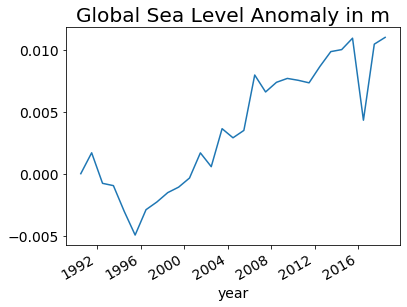

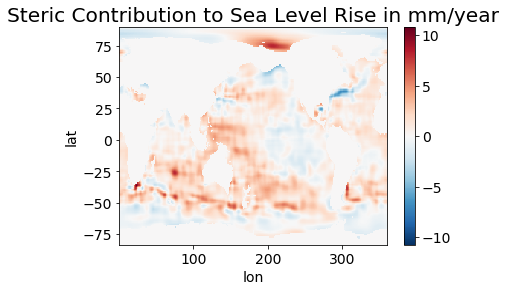

In [0]:
x = time.year.values

y = steric_height_anomaly.stack(features=["lon", "lat"])
y = y.fillna(0)

sla_global = y.mean("features")
sla_global.plot()
plt.title("Global Sea Level Anomaly in m")

model = LinearRegression()
model.fit(x[:, None], y)

A = model.coef_[:, 0]
A = xr.DataArray(A, dims=["features"], coords={"features": y["features"]})
A = A.unstack() * 1e3

plt.figure()
A.plot(x="lon", y="lat")
plt.title("Steric Contribution to Sea Level Rise in mm/year")
plt.show()

IllegalArgumentException: Invalid number of points in LinearRing found 3 - must be 0 or >= 4
Shell is not a LinearRing
IllegalArgumentException: Invalid number of points in LinearRing found 3 - must be 0 or >= 4
Shell is not a LinearRing
IllegalArgumentException: Invalid number of points in LinearRing found 3 - must be 0 or >= 4
Shell is not a LinearRing
IllegalArgumentException: Invalid number of points in LinearRing found 3 - must be 0 or >= 4
Shell is not a LinearRing
IllegalArgumentException: Invalid number of points in LinearRing found 3 - must be 0 or >= 4
Shell is not a LinearRing
IllegalArgumentException: Invalid number of points in LinearRing found 3 - must be 0 or >= 4
Shell is not a LinearRing


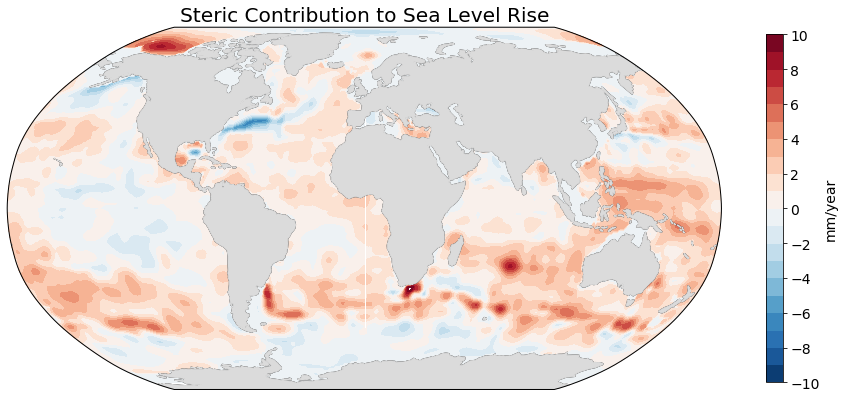

In [0]:
fig = plt.figure(figsize=(16, 8))

ax = fig.gca(projection=crs.Robinson())
ax.set_title("Steric Contribution to Sea Level Rise")
# vmax = max(-np.nanmin(A), np.nanmax(A))
# im = ax.pcolor(A["lon"], A["lat"], A.T, vmin=-vmax, vmax=vmax, cmap="RdBu_r", transform=crs.PlateCarree())
im = ax.contourf(A["lon"], A["lat"], A.T, levels=np.arange(-10,11,1), cmap="RdBu_r", transform=crs.PlateCarree())
fig.colorbar(im, ax=ax, ticks=np.arange(-10, 11, 2), label="mm/year", shrink=0.8)
ax.set_global()

ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.LAND, facecolor=cfeature.COLORS["land_alt1"])

plt.savefig("sea_level_rise_map.png", dpi=300, bbox_inches="tight")
plt.show()

## Influence of Temperature

In [0]:
time_start = 1990
time_end = 2018

PT1 = ds["temperature"].groupby('time.year').mean('time').sel(depth=slice(0, p_ref+200), year=slice(time_start, time_end)) - 273.15  # convert from Kelvin to Celsius
SP1 = ds["salinity"].groupby('time.year').mean('time').sel(depth=slice(0, p_ref+200), year=time_start)
time1 = ds["time"].groupby('time.year').mean('time').sel(year=slice(time_start, time_end))
TIME1, Z1, LAT1, LON1 = np.meshgrid(time1, z, lat, lon, indexing="ij")

print("Calculating pressure")
P1 = gsw.p_from_z(-Z1, LAT1)
print("Calculating absolute salinity")
SA1 = gsw.SA_from_SP(SP1, P1, LON1, LAT1)
print("Calculating conservative temperature")
CT1 = gsw.CT_from_pt(SA1, PT1)
print("Calculating steric height")
steric_height1 = gsw.geo_strf_dyn_height(SA1, CT1, P1, p_ref, axis=1)[:, 0] / g0

steric_height_anomaly1 = steric_height1 - steric_height1[0]
steric_height_anomaly1 = xr.DataArray(steric_height_anomaly1, dims=["year", "lat", "lon"], coords={"year": time1, "lat": lat, "lon": lon})

Calculating pressure
Calculating absolute salinity


/usr/local/lib/python3.6/dist-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


Calculating conservative temperature


/usr/local/lib/python3.6/dist-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


Calculating steric height


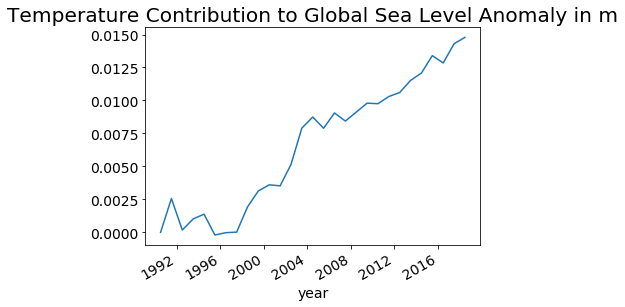

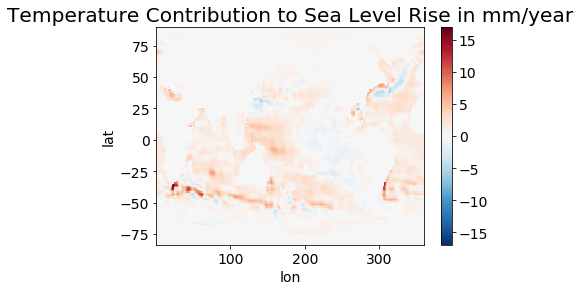

In [0]:
x1 = time1.year.values

y1 = steric_height_anomaly1.stack(features=["lon", "lat"])
y1 = y1.fillna(0)

sla_global1 = y1.mean("features")
sla_global1.plot()
plt.title("Temperature Contribution to Global Sea Level Anomaly in m")

model1 = LinearRegression()
model1.fit(x1[:, None], y1)

A1 = model1.coef_[:, 0]
A1 = xr.DataArray(A1, dims=["features"], coords={"features": y1["features"]})
A1 = A1.unstack() * 1e3

plt.figure()
A1.plot(x="lon", y="lat")
plt.title("Temperature Contribution to Sea Level Rise in mm/year")
plt.show()

## Influence of Salinity

In [0]:
time_start = 1990
time_end = 2018

PT2 = ds["temperature"].groupby('time.year').mean('time').sel(depth=slice(0, p_ref+200), year=time_start) - 273.15  # convert from Kelvin to Celsius
SP2 = ds["salinity"].groupby('time.year').mean('time').sel(depth=slice(0, p_ref+200), year=slice(time_start, time_end))
time2 = ds["time"].groupby('time.year').mean('time').sel(year=slice(time_start, time_end))
TIME2, Z2, LAT2, LON2 = np.meshgrid(time2, z, lat, lon, indexing="ij")

print("Calculating pressure")
P2 = gsw.p_from_z(-Z2, LAT2)
print("Calculating absolute salinity")
SA2 = gsw.SA_from_SP(SP2, P2, LON2, LAT2)
print("Calculating conservative temperature")
CT2 = gsw.CT_from_pt(SA2, PT2)
print("Calculating steric height")
steric_height2 = gsw.geo_strf_dyn_height(SA2, CT2, P2, p_ref, axis=1)[:, 0] / g0

steric_height_anomaly2 = steric_height2 - steric_height2[0]
steric_height_anomaly2 = xr.DataArray(steric_height_anomaly2, dims=["year", "lat", "lon"], coords={"year": time2, "lat": lat, "lon": lon})

Calculating pressure
Calculating absolute salinity


/usr/local/lib/python3.6/dist-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


Calculating conservative temperature


/usr/local/lib/python3.6/dist-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


Calculating steric height


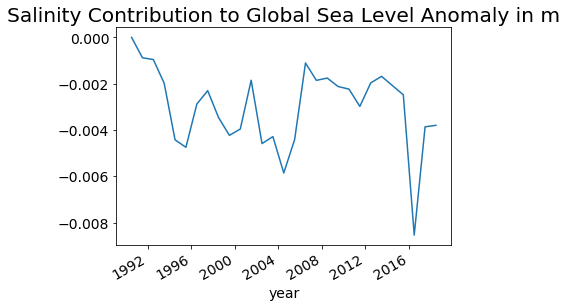

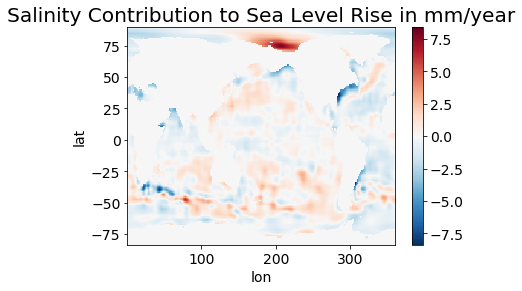

In [0]:
x2 = time2.year.values

y2 = steric_height_anomaly2.stack(features=["lon", "lat"])
y2 = y2.fillna(0)

sla_global2 = y2.mean("features")
sla_global2.plot()
plt.title("Salinity Contribution to Global Sea Level Anomaly in m")

model2 = LinearRegression()
model2.fit(x2[:, None], y2)

A2 = model2.coef_[:, 0]
A2 = xr.DataArray(A2, dims=["features"], coords={"features": y2["features"]})
A2 = A2.unstack() * 1e3

plt.figure()
A2.plot(x="lon", y="lat")
plt.title("Salinity Contribution to Sea Level Rise in mm/year")
plt.show()

# Comparison

## between influences and with LEGOS data

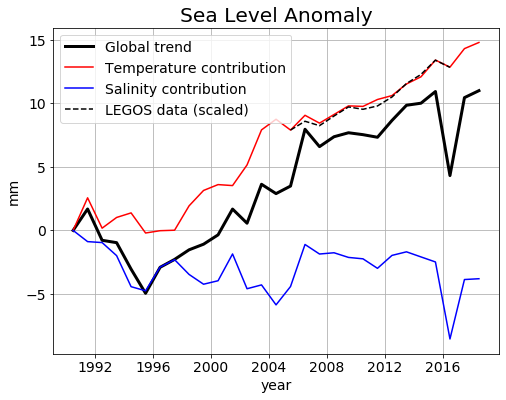

In [0]:
# Data from https://www.seanoe.org/data/00437/54854/
text = """2005.50	0
2006.50	1.82
2007.50	0.91
2008.50	2.9
2009.50	4.78
2010.50	4.29
2011.50	4.98
2012.50	6.83
2013.50	9.61
2014.50	11.49
2015.50	14.44
2016.50	12.96""".split("\n")
comp_years = [np.datetime64(k.split(".")[0] + "-07") for k in text]
comp_values = np.array([float(k.split()[1]) for k in text])

plt.figure(figsize=(8, 6))
plt.title("Sea Level Anomaly")
plt.xlabel("year")
plt.ylabel("mm")
plt.plot(y.year, sla_global * 1e3, "k", linewidth=3, label = "Global trend")
plt.plot(y1.year, sla_global1 * 1e3, "r", label = "Temperature contribution")
plt.plot(y2.year, sla_global2 * 1e3, "b", label = "Salinity contribution")
sla_offset0 = sla_global1.sel(year="2005") * 1e3
sla_offset1 = sla_global1.sel(year="2016") * 1e3
plt.plot(
    comp_years,
    comp_values * (sla_offset1.values - sla_offset0.values) / 13 + sla_offset0.values,
    "k--",
    label="LEGOS data (scaled)"
)

plt.grid()
plt.legend()

plt.savefig("sla_trend.png", dpi=300, bbox_inches="tight")
plt.show()

## with 2006-2008 Argo data

In [0]:
time_start = np.datetime64("2006")
time_end = np.datetime64("2009")  # end is exclusive, so it goes until December 2008

p_ref_Argo = 4000

z3 = ds["depth"].sel(depth=slice(0, p_ref_Argo+200))
PT3 = ds["temperature"].sel(depth=slice(0, p_ref_Argo+200), time=slice(time_start, time_end)) - 273.15  # convert from Kelvin to Celsius
SP3 = ds["salinity"].sel(depth=slice(0, p_ref_Argo+200), time=slice(time_start, time_end))
time3 = ds["time"].sel(time=slice(time_start, time_end))

TIME3, Z3, LAT3, LON3 = np.meshgrid(time3, z3, lat, lon, indexing="ij")

print("Calculating pressure")
P3 = gsw.p_from_z(-Z3, LAT3)
print("Calculating absolute salinity")
SA3 = gsw.SA_from_SP(SP3, P3, LON3, LAT3)
print("Calculating conservative temperature")
CT3 = gsw.CT_from_pt(SA3, PT3)
print("Calculating sterComparisonic height")
steric_height3 = gsw.geo_strf_dyn_height(SA3, CT3, P3, p_ref_Argo, axis=1)[:, 0] / g0

steric_height_anomaly3 = steric_height3 - steric_height3[0]
steric_height_anomaly3 = xr.DataArray(steric_height_anomaly3, dims=["time", "lat", "lon"], coords={"time": time3, "lat": lat, "lon": lon})

Calculating pressure
Calculating absolute salinity
Calculating conservative temperature
Calculating steric height


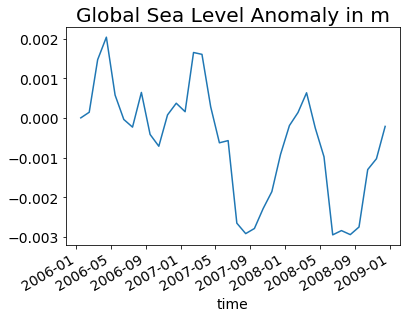

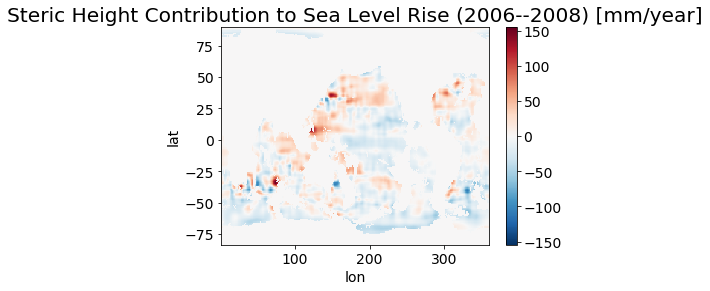

In [0]:
x3 = time3.values.astype("int")/(365.25 * 24 * 60 * 60 * 1e9)  # time in years since 1970

y3 = steric_height_anomaly3.stack(features=["lon", "lat"])
y3 = y3.fillna(0)

sla_global3 = y3.mean("features")
sla_global3.plot()
plt.title("Global Sea Level Anomaly in m")

model3 = LinearRegression()
model3.fit(x3[:, None], y3)

A3 = model3.coef_[:, 0]
A3 = xr.DataArray(A3, dims=["features"], coords={"features": y3["features"]})
A3 = A3.unstack() * 1e3

plt.figure()
A3.plot(x="lon", y="lat")
plt.title("Steric Height Contribution to Sea Level Rise (2006--2008) [mm/year]")
plt.show()

IllegalArgumentException: Invalid number of points in LinearRing found 3 - must be 0 or >= 4
Shell is not a LinearRing
IllegalArgumentException: Invalid number of points in LinearRing found 3 - must be 0 or >= 4
Shell is not a LinearRing


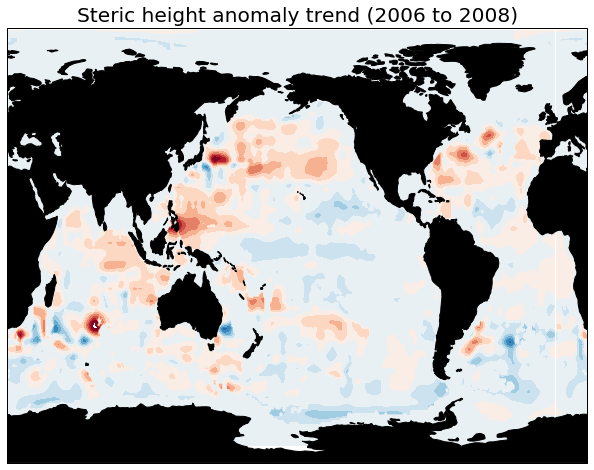

In [0]:
fig = plt.figure(figsize=(16, 8))

ax = fig.gca(projection=crs.PlateCarree(central_longitude=200))
ax.set_title("Steric height anomaly trend (2006 to 2008)")
vmax = max(-np.nanmin(A3), np.nanmax(A3))
im = ax.contourf(A3["lon"], A3["lat"], A3.T, levels=np.arange(-140, 150, 20), cmap="RdBu_r", transform=crs.PlateCarree())
ax.set_global()
ax.set_aspect(3/2)

ax.add_feature(cfeature.LAND, facecolor="black")

plt.savefig("steric_height_anomaly_trend_2006-2008.png", dpi=300, bbox_inches="tight")
plt.show()

# Global Temperature and Salinity Trends

In [0]:
T_global = ds["temperature"].groupby('time.year').mean('time').sel(depth=slice(0, p_ref+200), year=slice(time_start, time_end)).mean(['lat', 'lon', 'depth']) - 273.15  # convert from Kelvin to Celsius
S_global = ds["salinity"].groupby('time.year').mean('time').sel(depth=slice(0, p_ref+200), year=slice(time_start, time_end)).mean(['lat', 'lon', 'depth'])

/usr/local/lib/python3.6/dist-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


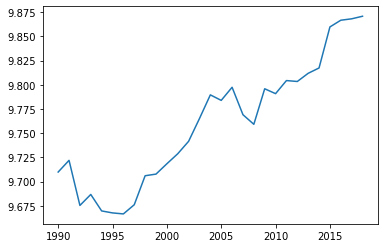

In [0]:
plt.plot(T_global.year, T_global)

/usr/local/lib/python3.6/dist-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


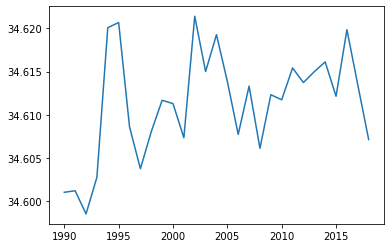

In [0]:
plt.plot(S_global.year, S_global)